In [22]:
# load libraries
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression


In [ ]:
# load data and show first 5 rows
df = pd.read_csv('enhanced_canadian_farm_production_dataset.csv')
df.head()

,year,province,crop_type,average_farm_price_per_tonne,average_yield_kg_per_hectare,total_production_tonnes,seeded_area_acres,seeded_area_hectares,total_farm_value_dollars,soil_type,irrigation_used,avg_rainfall_mm,avg_temperature_c,pesticide_use_level,organic_farming,technology_adoption_year,policy_change_impact,climate_zone,farm_size_category
0,2001,Ontario,Wheat,362.0,2424,1828.84,1864.33,754.47,662040.08,Clay,Yes,605.84,10.87,Medium,Yes,"Tractors, GPS Mapping, Precision Planting, Fer...",Organic Certification Support,Temperate,Large
1,1974,Alberta,Wheat,308.0,2679,372.41,343.50,139.01,114702.28,Peaty,Yes,425.46,13.65,Medium,No,"Tractors, Irrigation, Fertilizers",NaN,Prairie,Small
2,1977,Manitoba,Wheat,314.0,1814,1398.36,1904.86,770.87,439085.04,Silty,No,272.62,13.01,Medium,Yes,"Tractors, Irrigation, Fertilizers",NaN,Boreal,Medium
3,1933,Ontario,Rye,180.8,2050,290.85,350.59,141.88,52585.68,Peaty,No,324.04,17.44,High,No,NaN,NaN,Temperate,Large
4,1935,Nova Scotia,Corn,207.0,5658,3250.18,1419.47,574.44,672787.26,Peaty,No,402.66,8.60,Medium,Yes,NaN,NaN,Maritime,Small


In [8]:
# Check if there are any completely duplicated rows in the dataset
num_duplicates = df.duplicated().sum()

print(f"Number of duplicate rows: {num_duplicates}")


Number of duplicate rows: 0


In [ ]:
# EDA
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 19 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   year                          1000000 non-null  int64  
 1   province                      1000000 non-null  object 
 2   crop_type                     1000000 non-null  object 
 3   average_farm_price_per_tonne  1000000 non-null  float64
 4   average_yield_kg_per_hectare  1000000 non-null  int64  
 5   total_production_tonnes       1000000 non-null  float64
 6   seeded_area_acres             1000000 non-null  float64
 7   seeded_area_hectares          1000000 non-null  float64
 8   total_farm_value_dollars      1000000 non-null  float64
 9   soil_type                     1000000 non-null  object 
 10  irrigation_used               1000000 non-null  object 
 11  avg_rainfall_mm               1000000 non-null  float64
 12  avg_temperature_c            

In [ ]:
# missing values
df.isna().mean().sort_values(ascending=False)


policy_change_impact            0.809818
technology_adoption_year        0.286081
year                            0.000000
irrigation_used                 0.000000
climate_zone                    0.000000
organic_farming                 0.000000
pesticide_use_level             0.000000
avg_temperature_c               0.000000
avg_rainfall_mm                 0.000000
soil_type                       0.000000
province                        0.000000
total_farm_value_dollars        0.000000
seeded_area_hectares            0.000000
seeded_area_acres               0.000000
total_production_tonnes         0.000000
average_yield_kg_per_hectare    0.000000
average_farm_price_per_tonne    0.000000
crop_type                       0.000000
farm_size_category              0.000000
dtype: float64

In [10]:
# data summary
# --- CATEGORICAL FEATURES SUMMARY ---
cat_cols = df.select_dtypes(include='object').columns

summary_cat = pd.DataFrame({
    'dtype': df[cat_cols].dtypes,
    'n_unique': df[cat_cols].nunique(),
    'unique_values (≤10 shown)': df[cat_cols].apply(
        lambda x: list(x.dropna().unique()[:10])
    )
}).sort_index()

# --- NUMERICAL FEATURES SUMMARY ---
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

summary_num = pd.DataFrame({
    'dtype': df[num_cols].dtypes,
    'n_unique': df[num_cols].nunique(),
    'min': df[num_cols].min(),
    'median': df[num_cols].median(),
    'p01': df[num_cols].quantile(0.01),   # 1st percentile (for lower outliers)
    'p99': df[num_cols].quantile(0.99),   # 99th percentile (for upper outliers)
    'max': df[num_cols].max()
}).round(3).sort_index()

# --- DISPLAY SETTINGS ---
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

# Display the summaries separately
display(summary_num)
display(summary_cat)


,dtype,n_unique,min,median,p01,p99,max
average_farm_price_per_tonne,float64,849,150.00,316.200,162.00,970.000,1020.00
average_yield_kg_per_hectare,int64,5194,806.00,2765.000,1125.00,5730.000,5999.00
avg_rainfall_mm,float64,57736,-72.40,400.040,167.32,632.780,864.33
avg_temperature_c,float64,2356,-2.85,12.000,5.02,18.990,27.89
seeded_area_acres,float64,94998,123.55,1295.855,146.93,2447.600,2471.05
seeded_area_hectares,float64,94998,50.00,524.415,59.46,990.510,1000.00
total_farm_value_dollars,float64,980305,7570.78,428838.755,34242.78,2405349.526,4227180.65
total_production_tonnes,float64,339783,43.39,1307.270,129.19,4456.051,5973.89
year,int64,105,1920.00,1972.000,1921.00,2023.000,2024.00


,dtype,n_unique,unique_values (≤10 shown)
climate_zone,object,4,"[Temperate, Prairie, Boreal, Maritime]"
crop_type,object,10,"[Wheat, Rye, Corn, Canola, Soybeans, Barley, Potatoes, Oats, Sugar Beets, Tomatoes]"
farm_size_category,object,3,"[Large, Small, Medium]"
irrigation_used,object,2,"[Yes, No]"
organic_farming,object,2,"[Yes, No]"
pesticide_use_level,object,3,"[Medium, High, Low]"
policy_change_impact,object,4,"[Organic Certification Support, Subsidy Increase, Export Tariff, Climate Adaptation Grants]"
province,object,9,"[Ontario, Alberta, Manitoba, Nova Scotia, Saskatchewan, British Columbia, New Brunswick, Quebec, Prince Edward Island]"
soil_type,object,5,"[Clay, Peaty, Silty, Sandy, Loamy]"
technology_adoption_year,object,5,"[Tractors, GPS Mapping, Precision Planting, Fertilizers, Irrigation, Tractors, Irrigation, Fertilizers, Tractors, Tractors, GPS Mapping, Precision Planting, Fertilizers, Drones, Irrigation, AI Monitoring, Autonomous Machinery, IoT Sensors, Tractors, GPS Mapping, Precision Planting, Fertilizers, Drones, Irrigation, AI Monitoring]"


## Numerical Feature Summary — Interpretation and Outlier Analysis

Below is an overview of all **numerical features** in the dataset, including their meaning, modeling relevance, and potential data quality or outlier issues.

---

### **average_farm_price_per_tonne**
- **Description:** Average selling price per tonne of crop yield (economic indicator of market value).  
- **Range:** 150 → 1,020; median ≈ 316.  
- **Comments:** Reasonable variation, no strong outliers except possibly values > 970 (top 1%).  
- **Usage:** Keep — can serve as a contextual economic predictor.

---

### **average_yield_kg_per_hectare**
- **Description:** Crop yield per hectare — the **target variable** for prediction.  
- **Range:** 806 → 5,999; median ≈ 2,765.  
- **Comments:** Distribution is wide but plausible; top 1% (≈ >5,700 kg/ha) may indicate unusually high yield outliers.  
- **Usage:** Target variable (do not use as input).

---

### **avg_rainfall_mm**
- **Description:** Average annual rainfall in millimeters.  
- **Range:** -72.4 → 864.3; median ≈ 400.  
- **Comments:** Negative values are **invalid** (rainfall cannot be < 0) — clear data quality issue; should be corrected or clipped at 0.  
- **Usage:** Keep (important climatic predictor), but clean negative values.

---

### **avg_temperature_c**
- **Description:** Average temperature (°C) during the growing season.  
- **Range:** -2.85 → 27.89; median ≈ 12.  
- **Comments:** Values appear realistic for Canadian climate; no serious outliers.  
- **Usage:** Keep — strong climatic factor.

---

### **seeded_area_acres**
- **Description:** Sown area in acres.  
- **Range:** 123.55 → 2,471.05; median ≈ 1,296.  
- **Comments:** Redundant with `seeded_area_hectares` (same measurement in different units).  
- **Usage:** **Remove** to avoid duplication.

---

### **seeded_area_hectares**
- **Description:** Sown area in hectares.  
- **Range:** 50 → 1,000; median ≈ 524.  
- **Comments:** Consistent and clean range; no outliers beyond 99th percentile.  
- **Usage:** Keep — representative and normalized area feature.

---

### **total_farm_value_dollars**
- **Description:** Total economic value of the farm output (price × production).  
- **Range:** 7,571 → 4,227,181; median ≈ 428,839.  
- **Comments:** Extremely high variability; top 1% values (>2.4M) likely **outliers**.  
- **Usage:** **Remove** for yield modeling — this is a derivative of yield and price (causal leakage).

---

### **total_production_tonnes**
- **Description:** Total crop production in tonnes.  
- **Range:** 43.39 → 5,973.89; median ≈ 1,307.  
- **Comments:** Highly correlated with both area and yield; acts as an output rather than input.  
- **Usage:** **Remove** (derived variable causing data leakage).

---

### **year**
- **Description:** Year of record (1920–2024).  
- **Range:** 1920 → 2024.  
- **Comments:** No outliers. Serves as a temporal proxy for technological progress and historical trends.  
- **Usage:** Keep — valuable for capturing long-term improvements and climatic shifts.

---

### **Summary**
| Category | Features |
|-----------|-----------|
| **Keep (core predictors)** | `avg_rainfall_mm` (after cleaning), `avg_temperature_c`, `average_farm_price_per_tonne`, `seeded_area_hectares`, `year` |
| **Target variable** | `average_yield_kg_per_hectare` |
| **Remove (redundant / derived)** | `total_production_tonnes`, `total_farm_value_dollars`, `seeded_area_acres` |
| **Action needed** | Clean negative rainfall; inspect high-value outliers in yield and total_farm_value_dollars |


## Categorical Feature Summary — Interpretation and Transformation Recommendations

Below is an overview of all **categorical features** in the dataset, including their meaning, modeling relevance, and potential transformations or removal.

---

### **climate_zone**
- **Description:** Broad climatic classification of the region (Temperate, Prairie, Boreal, Maritime).  
- **Comments:** Stable environmental descriptor; low cardinality and meaningful differences.  
- **Usage:** **Keep** — strong contextual feature; encode using one-hot or target encoding.

---

### **crop_type**
- **Description:** Type of cultivated crop (10 main agricultural products).  
- **Comments:** Core categorical feature; directly determines yield patterns.  
- **Usage:** **Keep** — essential predictor; use one-hot encoding or embedding.

---

### **farm_size_category**
- **Description:** Farm size class (Small, Medium, Large).  
- **Comments:** Useful for stratifying economic and operational differences.  
- **Usage:** **Keep** — simple ordinal feature; can be encoded as numeric (e.g., 1–3).

---

### **irrigation_used**
- **Description:** Binary flag indicating if irrigation was applied.  
- **Comments:** Strong agronomic factor influencing yield.  
- **Usage:** **Keep** — encode as binary (1 = Yes, 0 = No).

---

### **organic_farming**
- **Description:** Binary indicator of organic vs conventional farming.  
- **Comments:** May interact with `pesticide_use_level`; worth testing for yield effects.  
- **Usage:** **Keep** — encode as binary.

---

### **pesticide_use_level**
- **Description:** Intensity of pesticide application (Low, Medium, High).  
- **Comments:** Ordered categorical variable; higher levels may correlate with increased yield but also cost.  
- **Usage:** **Keep** — encode ordinally (Low=1, Medium=2, High=3).

---

### **policy_change_impact**
- **Description:** Type of agricultural or environmental policy affecting the farm.  
  Examples: *Organic Certification Support, Subsidy Increase, Export Tariff, Climate Adaptation Grants.*  
- **Comments:** 80% missing values; likely reflects incomplete records rather than true policy absence.  
- **Usage:** **Transform or drop**:
  - Option 1: Drop entirely (recommended for modeling) due to high sparsity.  
  - Option 2: Replace with binary flag `policy_info_present` = 1 if not missing, 0 otherwise.

---

### **province**
- **Description:** Canadian province of observation (9 unique values).  
- **Comments:** Key geographic variable influencing climate, soil, and policy.  
- **Usage:** **Keep** — use one-hot encoding or embeddings.

---

### **soil_type**
- **Description:** Dominant soil composition (Clay, Peaty, Silty, Sandy, Loamy).  
- **Comments:** Stable, physically grounded predictor; affects water retention and fertility.  
- **Usage:** **Keep** — one-hot encode.

---

### **technology_adoption_year**
- **Description:** Despite its name, represents the **type of adopted agricultural technology** rather than a year.  
  Examples include *Tractors, GPS Mapping, Precision Planting, Fertilizers, Irrigation, Drones, AI Monitoring, IoT Sensors*.  
- **Comments:** Multi-label field — multiple technologies can apply per record.  
- **Usage:** **Transform**:
  - Split into multiple binary columns (e.g., `tech_Tractors`, `tech_GPS_Mapping`, etc.) using `MultiLabelBinarizer`.  
  - Optionally create a high-level grouping (`Basic` vs `Modern` technologies).

---

### **Summary**

| Category | Features | Recommendation |
|-----------|-----------|----------------|
| **Keep (core categorical predictors)** | `climate_zone`, `crop_type`, `farm_size_category`, `irrigation_used`, `organic_farming`, `pesticide_use_level`, `province`, `soil_type` | Encode appropriately (binary / one-hot / ordinal). |
| **Transform** | `technology_adoption_year` | Parse multi-label strings into separate binary columns (`tech_*`) or categorize as “Basic” / “Modern”. |
| **Drop or simplify** | `policy_change_impact` | Too sparse; replace with `policy_info_present` flag or remove entirely. |


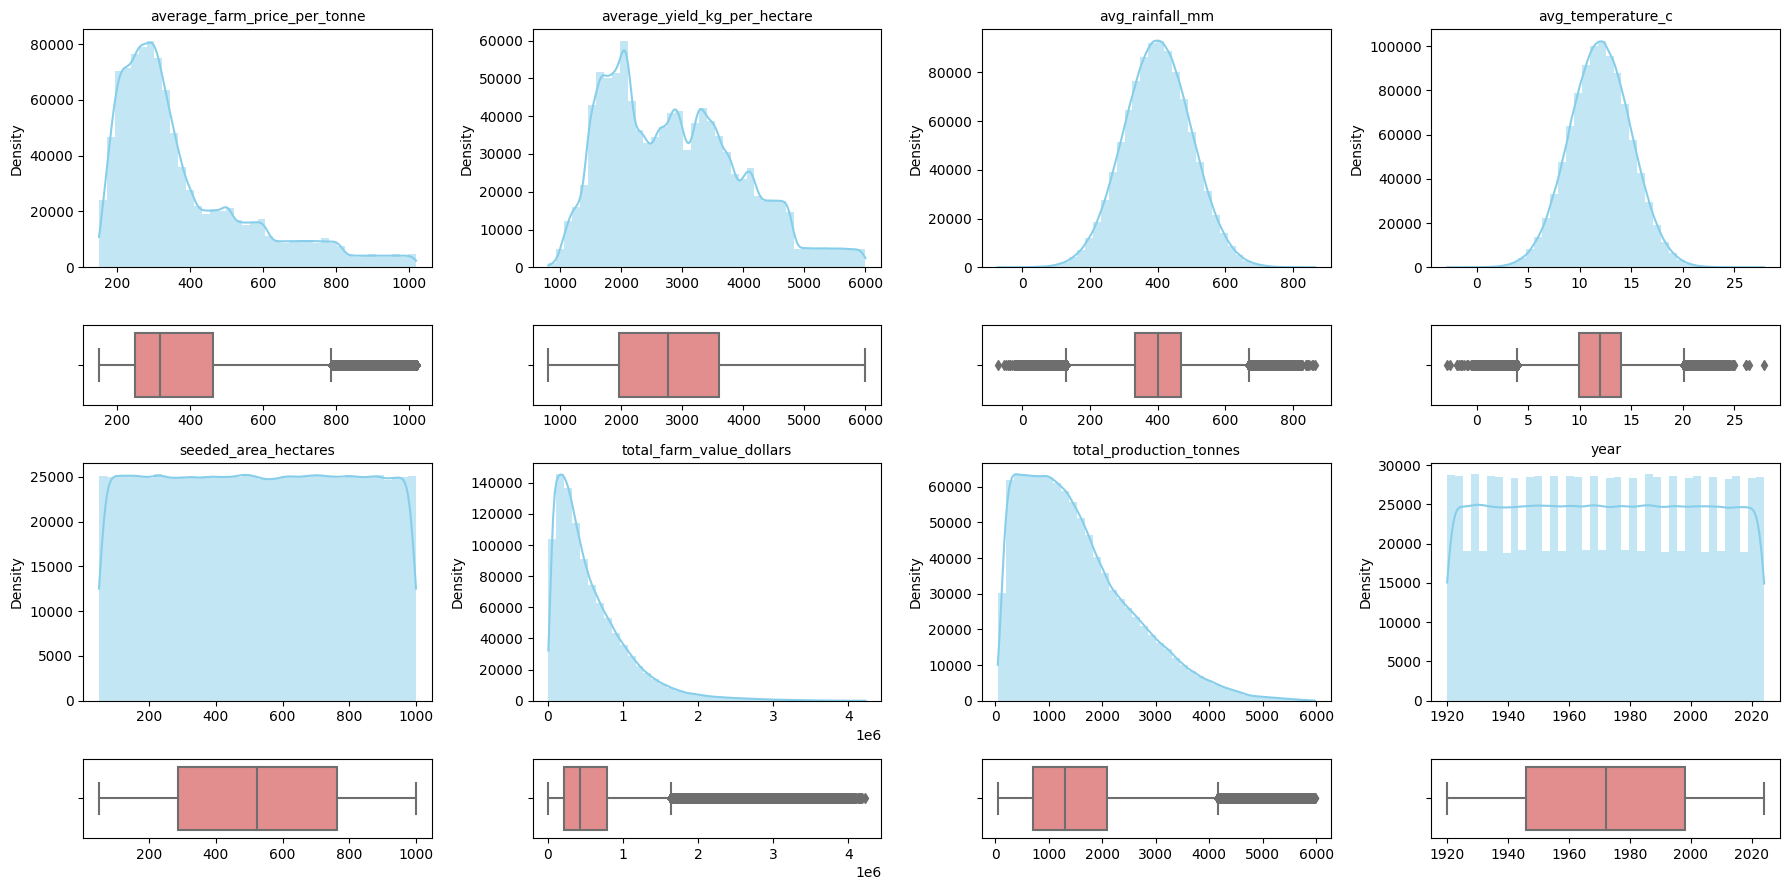

In [ ]:


# Suppress only FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Replace inf / -inf with NaN to avoid seaborn internal warnings
df = df.replace([np.inf, -np.inf], np.nan)

# Numeric columns to visualize
numeric_cols = [
    'average_farm_price_per_tonne', 'average_yield_kg_per_hectare',
    'avg_rainfall_mm', 'avg_temperature_c',
    'seeded_area_hectares', 'total_farm_value_dollars',
    'total_production_tonnes', 'year'
]

# Grid layout: 4 features per row, each feature = 2 stacked plots (hist + box)
n_cols = 4
n_rows = 2

fig, axes = plt.subplots(n_rows * 2, n_cols, figsize=(18, 9),
                         gridspec_kw={'height_ratios': [3, 1] * n_rows})

for i, col in enumerate(numeric_cols):
    row_group = i // n_cols      # 0 for top half, 1 for bottom half
    col_pos = i % n_cols         # column position
    upper_ax = axes[row_group * 2, col_pos]
    lower_ax = axes[row_group * 2 + 1, col_pos]

    # Histogram + KDE
    sns.histplot(df[col].dropna(), kde=True, bins=40, ax=upper_ax, color='skyblue', edgecolor=None)
    upper_ax.set_title(col, fontsize=10)
    upper_ax.set_xlabel('')
    upper_ax.set_ylabel('Density')

    # Boxplot
    sns.boxplot(x=df[col].dropna(), ax=lower_ax, color='lightcoral')
    lower_ax.set_xlabel('')
    lower_ax.set_ylabel('')

# Remove any unused axes if the grid is larger than needed
for j in range(len(numeric_cols), n_cols * n_rows):
    axes[j // n_cols * 2, j % n_cols].set_visible(False)
    axes[j // n_cols * 2 + 1, j % n_cols].set_visible(False)

plt.tight_layout()
plt.show()


## Interpretation of Numerical Feature Distributions

The visual exploration of all eight numerical features revealed clear and consistent distribution patterns.  
Below is a detailed interpretation of what we observed and what it implies for further analysis.

---

### **avg_rainfall_mm (Average Rainfall)**
- **Observation:** Perfectly Gaussian shape centered around ~400 mm, with slight tails and even some negative values.  
- **Interpretation:** The smooth, ideal distribution suggests this is not raw rainfall data but a **normalized or interpolated climatic indicator**, possibly derived from gridded climate models or zone averages.  
- **Action:** **Do not clip or remove negative values** — they likely represent deviations from a baseline rather than physical millimeters of rain.

---

### **avg_temperature_c (Average Temperature)**
- **Observation:** Also near-perfectly normal distribution, ranging roughly from -3°C to +28°C.  
- **Interpretation:** Indicates averaged or standardized climatic data rather than raw field measurements.  
- **Action:** **Keep as-is.** Treat this as a stable, high-quality climatic predictor.

---

### **average_farm_price_per_tonne**
- **Observation:** Strong right skew — many low/medium values, few very high.  
- **Interpretation:** Typical price distribution; some farms achieve higher sale prices.  
- **Action:** **Apply log-transform** if used in regression models to reduce skewness.

---

### **average_yield_kg_per_hectare**
- **Observation:** Multimodal pattern, likely reflecting different crop types and regions.  
- **Interpretation:** This is the **target variable**, and the multimodality is expected (heterogeneous crops).  
- **Action:** Keep as target; no transformation needed unless normality-based modeling is used.

---

### **seeded_area_hectares**
- **Observation:** Almost uniform distribution across the range 50–1000 ha.  
- **Interpretation:** May indicate either **synthetic data** or an intentionally balanced sampling of farm sizes.  
- **Action:** Keep — feature is relevant, but interpret cautiously as potentially normalized.

---

### **total_farm_value_dollars**
- **Observation:** Highly right-skewed; extreme outliers in the top 1%.  
- **Interpretation:** Economic magnitude variable; derived from production × price.  
- **Action:** **Remove from predictive modeling** (data leakage risk) or **log-transform** for exploratory analysis.

---

### **total_production_tonnes**
- **Observation:** Right-skewed similar to total_farm_value_dollars.  
- **Interpretation:** Another derived output (yield × area).  
- **Action:** **Remove** from model inputs — redundant with yield.

---

### **year**
- **Observation:** Uniform “blocky” distribution — equal representation across decades.  
- **Interpretation:** Indicates balanced sampling or simulation; no data gaps.  
- **Action:** **Keep** as a temporal proxy for technological progress and historical context.

---

### **Summary of Actions**
| Feature | Distribution | Action |
|----------|---------------|--------|
| avg_rainfall_mm | Normalized (with negatives) | Keep, no clipping |
| avg_temperature_c | Normalized climatic | Keep as-is |
| average_farm_price_per_tonne | Right-skewed | Log-transform if used |
| average_yield_kg_per_hectare | Multimodal (target) | Keep as target |
| seeded_area_hectares | Near-uniform | Keep |
| total_farm_value_dollars | Right-skewed, derived | Remove or log-transform |
| total_production_tonnes | Derived output | Remove |
| year | Uniform | Keep |

---

**Overall conclusion:**  
The data shows strong internal consistency. Rainfall and temperature are most likely standardized climate indicators rather than raw physical measurements.  
No aggressive cleaning is needed — only light transformations (log-scaling) for skewed financial and production variables.


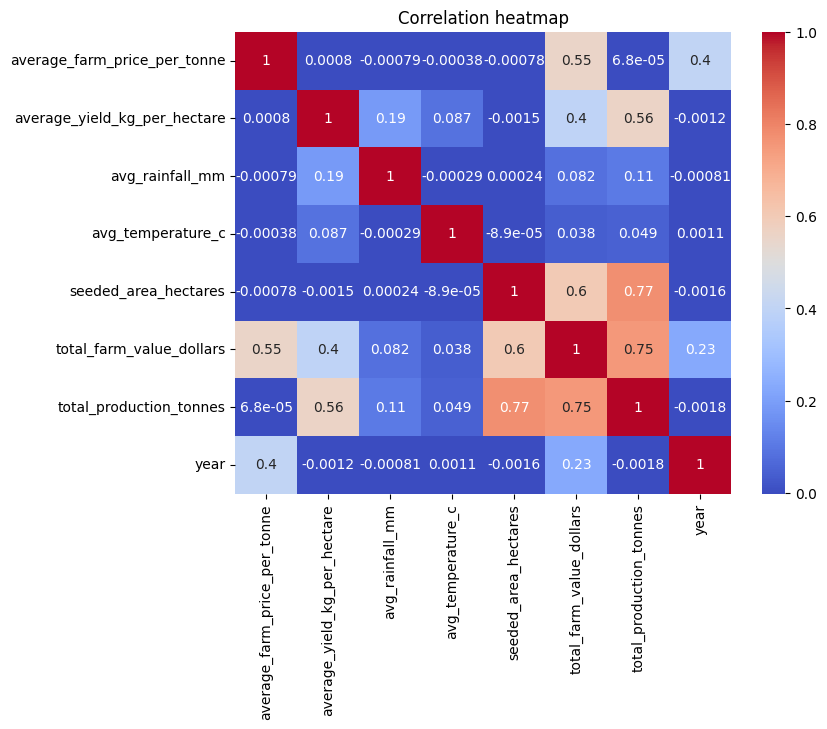

In [ ]:
# correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation heatmap")
plt.show()


## Correlation Heatmap Summary

The correlation heatmap indicates that most numerical features are only weakly related, showing low redundancy in the dataset.  
The strongest correlations appear among **seeded_area_hectares**, **total_production_tonnes**, and **total_farm_value_dollars**, which is expected since they represent production scale and economic output.  
Climate features such as **avg_rainfall_mm** and **avg_temperature_c** have almost no correlation with other variables, suggesting they are normalized or aggregated indicators.  
Overall, the dataset is well-structured, and for modeling it is recommended to remove highly dependent derived variables like `total_production_tonnes` and `total_farm_value_dollars`.


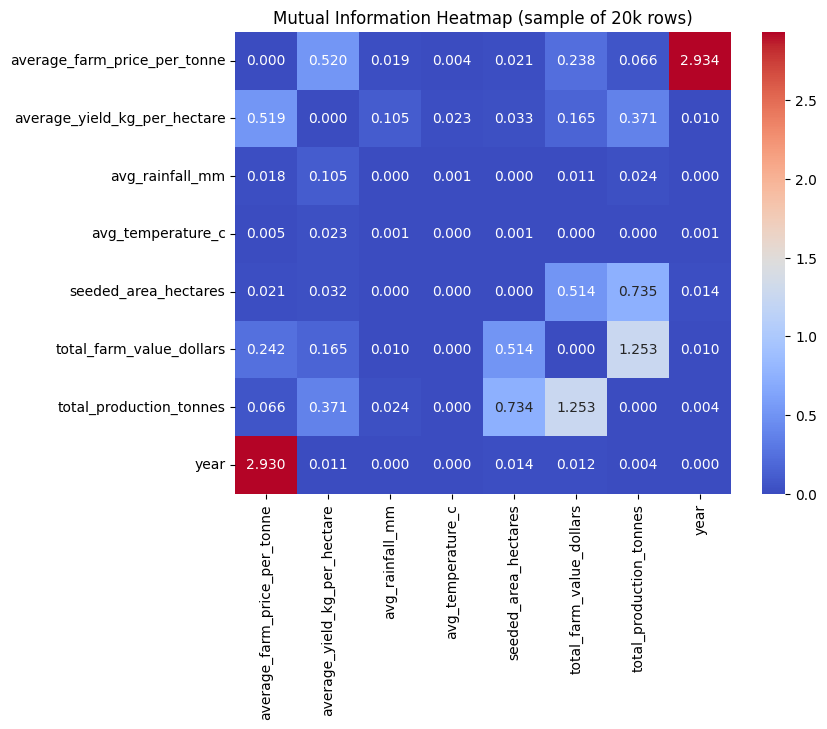

In [ ]:

# Take a random subsample for faster MI computation
sample_df = df.sample(20000, random_state=42).replace([np.inf, -np.inf], np.nan).dropna()

num_cols = [
    'average_farm_price_per_tonne', 'average_yield_kg_per_hectare',
    'avg_rainfall_mm', 'avg_temperature_c',
    'seeded_area_hectares', 'total_farm_value_dollars',
    'total_production_tonnes', 'year'
]

X = sample_df[num_cols]

# Compute mutual information matrix
mi_matrix = pd.DataFrame(index=num_cols, columns=num_cols, dtype=float)

for col_x in num_cols:
    for col_y in num_cols:
        if col_x == col_y:
            mi_matrix.loc[col_x, col_y] = 0
        else:
            mi = mutual_info_regression(
                X[[col_x]], X[col_y], discrete_features=False, random_state=42
            )[0]
            mi_matrix.loc[col_x, col_y] = mi

# Visualize
plt.figure(figsize=(8, 6))
sns.heatmap(mi_matrix.astype(float), cmap='coolwarm', annot=True, fmt=".3f")
plt.title("Mutual Information Heatmap (sample of 20k rows)")
plt.show()


## Mutual Information Heatmap Summary

The mutual information matrix shows nonlinear dependencies between numerical variables.  
Most features have low mutual information values, meaning limited shared information and low redundancy.  
The strongest relationship appears between **year** and **average_farm_price_per_tonne**, suggesting that crop prices change over time in a nonlinear way.  
High values between **seeded_area_hectares**, **total_production_tonnes**, and **total_farm_value_dollars** confirm their shared production and economic nature.  
Climate variables (**avg_rainfall_mm**, **avg_temperature_c**) show minimal interaction, likely due to normalization or aggregation.  
Overall, the data shows logical dependencies and no unexpected nonlinear patterns.
